# Experiment: Level-spacing ratio statistics

Experiment (Fig. 3): compute unfolding-free level-spacing ratio statistics r from sampled thermal states, and compare initial vs output ensembles against Poisson/GOE predictions.

In [2]:
import torch
import numpy as np
from scipy.linalg import expm

import quairkit as qkit
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from gibbs import *

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.family": "STIXGeneral",
    "mathtext.fontset": "cm",

    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,

    "lines.linewidth": 1.2,
    "lines.markersize": 3.5,

    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.major.size": 3.0,
    "ytick.major.size": 3.0,

    "axes.labelpad": 2,
})


Since sampling algorithm involve random processes and measurements, we set a random seed for reproducibility.

In [5]:
qkit.set_seed(20260107)
qkit.get_seed()

20260107

## Experimental setting

Prepare Hamiltonian

In [6]:
n, hamiltonian = build_2d_tfim(3, 3, J=0.1, h=0.025)

In [7]:
lb, si, sites = hamiltonian.decompose_with_sites()
xi = sum([abs(coef) for coef in lb])

beta = 2

error_level = 3
error = 10 ** (-error_level)

num_step = int(np.ceil((xi ** 2) * (beta ** 2) / (error ** (2 / 3))))

In [8]:
num_sample = 20

Prepare input state such that its level statistic is Poisson

In [9]:
_, hamiltonian_init = build_2d_heisenberg(3, 3, Jz=1.0, Jxy=0.0, hz=0.3, hx=0.5)
init_state = torch.linalg.matrix_exp(-1 * 1 * hamiltonian_init.matrix).real
init_state = init_state / torch.trace(init_state)
init_state = qkit.to_state(init_state)

In [ ]:
list_state, sample_coef, sample_error, list_prob = algorithm1(
    n=n,
    beta=beta,
    hamiltonian=hamiltonian,
    error=error,
    num_sample=num_sample,
    num_step=num_step,
    init_state=init_state,
    save_dir="data",
    save_tag="level_statistic",
    save_state=True,
    save_compressed=True,
)

list_state = list_state.density_matrix

In [ ]:
list_state_init = torch.stack([init_state.density_matrix for _ in range(num_sample)])

In [ ]:
stats = r_stats_from_gibbs_states(
    list_state,
    bulk_keep=1.0,
    drop_small_eigs=True,
    rank_tol_rel=1e-12, #tolerance for treating eigenvalues as zero
    dedup=True, #whether to deduplicate near-degenerate levels
    dedup_on="mu", #evals: deduplicate based on eigenvalues of rho; mu: deduplicate based on -log rho
    dedup_keep="first",  # keep one level from each degenerate cluster
    dedup_tol_rel=1e-6, #tolerance for deduplication
    return_debug=True,
)

stats_init = r_stats_from_gibbs_states(
    list_state_init,
    bulk_keep=1.0,
    drop_small_eigs=True,
    rank_tol_rel=1e-12,
    dedup=True,
    dedup_on="mu", #evals: deduplicate based on eigenvalues of rho; mu: deduplicate based on -log rho
    dedup_keep="first",  # keep one level from each degenerate cluster
    dedup_tol_rel=1e-6, #tolerance for deduplication
    return_debug=True,
)

In [ ]:
np.savez_compressed("data/level_statistic.npz", stats=stats, stats_init=stats_init)

We also provide saved data to save computation time.

In [ ]:
# stats = np.load("data/level_statistic.npz", allow_pickle=True)["stats"].item()
# stats_init = np.load("data/level_statistic.npz", allow_pickle=True)["stats_init"].item()

In [15]:
# -------------------------
# Load data from stats
# -------------------------
edges    = stats["hist_edges"]
hist_y_a = stats["hist_counts"]       # Final
hist_y_b = stats_init["hist_counts"]  # Init

label_a = "Final Gibbs"
label_b = "Initial"
color_a = "C0"
color_b = "C1"
r_cut   = 0.05
ngrid   = 2000

# -------------------------
# Cast to numpy
# -------------------------
edges    = np.asarray(edges, dtype=float)
hist_y_a = np.asarray(hist_y_a, dtype=float)
hist_y_b = np.asarray(hist_y_b, dtype=float)

# -------------------------
# Bin centers / widths
# -------------------------
centers = 0.5 * (edges[:-1] + edges[1:])
widths  = edges[1:] - edges[:-1]

# -------------------------
# Main mask (r >= r_cut)
# -------------------------
mask_main = centers >= r_cut
c_main = centers[mask_main]
w_main = widths[mask_main]

# -------------------------
# Normalize on r >= r_cut
# -------------------------
y_a = hist_y_a[mask_main].copy()
area_a = np.sum(y_a * w_main)
if area_a <= 0:
    raise ValueError("No mass in dataset A for r >= r_cut.")
y_a = y_a / area_a

y_b = hist_y_b[mask_main].copy()
area_b = np.sum(y_b * w_main)
if area_b <= 0:
    raise ValueError("No mass in dataset B for r >= r_cut.")
y_b = y_b / area_b

# -------------------------
# Theoretical curves (GOE / Poisson) on [r_cut, 1]
# -------------------------
r = np.linspace(r_cut, 1.0, ngrid)

P_goe = (27/8) * (r + r**2) / (1 + r + r**2)**(2.5)
P_poi = 2 / (1 + r)**2

# conditional normalization on [r_cut, 1]
P_goe = P_goe / np.trapezoid(P_goe, r)
P_poi = P_poi / np.trapezoid(P_poi, r)

## Plot

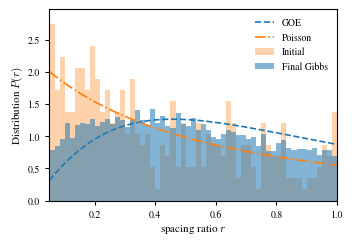

In [16]:
# -------------------------
# Plot
# -------------------------
FIGSIZE = (3.375, 2.30)   # single-column width with a PRL-like height
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.bar(
    c_main, y_b, width=w_main, align="center",
    alpha=0.35, edgecolor="none", color=color_b,
    label=label_b,
)
ax.bar(
    c_main, y_a, width=w_main, align="center",
    alpha=0.55, edgecolor="none", color=color_a,
    label=label_a,
)

ax.plot(r, P_goe, "--", linewidth=1.2, label="GOE")
ax.plot(r, P_poi, "-.", linewidth=1.2, label="Poisson")

ax.set_xlim(r_cut, 1.0)
ax.set_xlabel(r"spacing ratio $r$")
ax.set_ylabel(r"Distribution $P(r)$")

ymax = max(np.max(y_a), np.max(y_b), np.max(P_goe), np.max(P_poi))
ax.set_ylim(0, 1.08 * ymax)

LEG_KW = dict(frameon=True, facecolor="white", edgecolor="none", framealpha=0.85)
ax.legend(loc="upper right", **LEG_KW)

fig.tight_layout(pad=0.2)
plt.show()


---

In [17]:
qkit.print_info()


---------VERSION---------
quairkit: 0.5.0
torch: 2.9.1
numpy: 2.2.6
scipy: 1.15.2
matplotlib: 3.10.8
---------SYSTEM---------
Python version: 3.10.19
OS: Darwin
OS version: Darwin Kernel Version 23.5.0: Wed May  1 20:14:38 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6020
---------DEVICE---------
CPU: Apple M2 Pro
